In [73]:
###  Buiding agentic chatbot with langgraph
from typing import Annotated
from  typing_extensions import TypedDict
from langgraph.graph import StateGraph,StateGraph,START,END
from langgraph.graph.message import add_messages

In [74]:
class State(TypedDict):
    messages:Annotated[list,add_messages]
    
graph_builder=StateGraph(State)

In [75]:
graph_builder

In [76]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [77]:
from langchain_groq import ChatGroq
from langchain.chat_models import  init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [78]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000013F4889D790>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000013F4889D7F0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [79]:
### Nide functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [80]:
graph_builder=StateGraph(State)

### Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# Compile the graph
graph=graph_builder.compile()
 

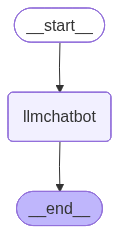

In [81]:
## visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
     pass

In [82]:
response=graph.invoke({"messages":"Hi"})

In [83]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='9e78b3b4-d750-496e-89b4-f05bd565473d'),
 AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.022607456, 'prompt_time': 0.002181049, 'queue_time': 0.090321351, 'total_time': 0.024788505}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e750f72ec9', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--6fb79bdf-5c04-467a-8f36-3fe62b5cf291-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})]

In [84]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [85]:
for event in graph.stream({"messages":"Hi How are you"}):
    for value  in event.values():
        print(value["messages"][-1].content)

I'm doing well, thank you for asking. It's nice to chat with you. How can I assist you today?


### Chabot with tool

In [86]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph?")

{'query': 'What is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [102]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b
    
    Args:
    a (int):first int
    b (int):second int
    
    Returns:
    int:output int
    """
    return a*b
     

In [103]:
tools=[tool,multiply]

In [104]:
llm_with_tools=llm.bind_tools(tools)

In [105]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000013F4889D790>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000013F4889D7F0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A

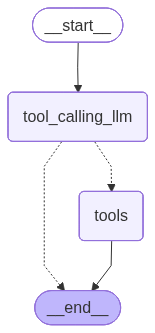

In [106]:
### stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode  
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
     return {"messages":[llm_with_tools.invoke(state["messages"])]}
 ##Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
  
 ## Add Edges
builder.add_edge(START, "tool_calling_llm")
# if the latest assistant message is a tool call --> route to "tools"
# otherwise --> route to END
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

### compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))
 
 

In [107]:
response=graph.invoke({"messages":"What is the recent ai news "})



In [108]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/innovations-in-bat-inspired-robotic-drones/", "title": "Innovations in Bat-Inspired Robotic Drones - Startup Ecosystem Canada", "score": 0.97838473, "published_date": "Thu, 13 Nov 2025 00:10:10 GMT", "content": "acquisition AI AI development AI infrastructure AI innovation AI integration AI investment AI models AI technology Anthropic Apple Artificial Intelligence Autonomous vehicles Canada founder news Canada startup news cryptocurrency Cybersecurity DeepSeek Electric Vehicles Elon Musk entrepreneurship fintech Funding round Generative AI Global founder news Global startup news healthcare innovation Innovation investment IPO Meta Microsoft Nvidia Ontario founder news Ontario startup news OpenAI Sam [...] ### Related Posts\\n\\n6 months ago Global AI Adoption Critical for Survival in Quant Trading, Says Baiont’s Feng Ji\\n\\n### AI Adoption C

In [109]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news 
================================== Ai Message ==================================
Tool Calls:
  tavily_search (xa6rjj4kg)
 Call ID: xa6rjj4kg
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/innovations-in-bat-inspired-robotic-drones/", "title": "Innovations in Bat-Inspired Robotic Drones - Startup Ecosystem Canada", "score": 0.97838473, "published_date": "Thu, 13 Nov 2025 00:10:10 GMT", "content": "acquisition AI AI development AI infrastructure AI innovation AI integration AI investment AI models AI technology Anthropic Apple Artificial Intelligence Autonomous vehicles Canada founder news Canada startup new

In [111]:
response = graph.invoke({"messages": "What is 2 multiplied by 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3
================================== Ai Message ==================================
Tool Calls:
  multiply (3zmnt69n6)
 Call ID: 3zmnt69n6
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
